In [224]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Utils

In [225]:
def read_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError("Check the img_path variable")
    return img

def show_img(img, title="Image", axis=False):
    plt.title(title)
    if not axis:
        plt.axis('off')
    plt.imshow(img, cmap='gray')

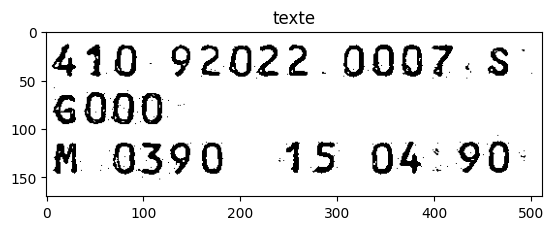

In [226]:
img_path = "img/texte.bmp"
img = read_img(img_path)

show_img(img, title="texte", axis=True)

# Profile of a Gray level image

In [227]:
def profile(img, offset, axis='H'):
    assert axis == "H" or axis == "V", "axis must be either 'H' or 'V'"
    assert offset >= 0, "The offset must be positive"
    if axis == "H":
        assert offset < img.shape[0], "the offset of a horizental profile\
            can't be greater than the number of rows of the image"
        
        return img[offset, :]
    else:
        assert offset < img.shape[1], "the offset of a vertical profile\
            can't be greater than the number of columns of the image"
        
        return img[:, offset]

def plot_profile(img, offset, axis='H'):
    profile_ = profile(img, offset, axis)
    plt.figure()
    axis_name = "Horizental" if axis=="H" else "Vertical"
    plt.title(axis_name + f" Profile at {offset}")
    plt.ylabel("NdG")
    plt.plot(range(len(profile_)), profile_)

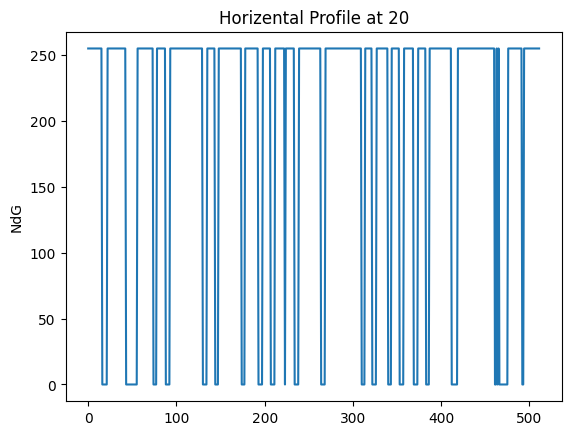

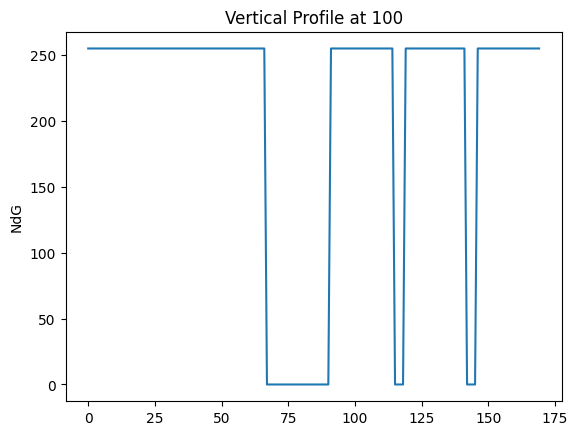

In [228]:
plot_profile(img, 20)
plot_profile(img, 100, "V")

# Projection of a Gray level image

In [229]:
def projection(img, offset, axis='H'):
    return profile(img, offset, axis).sum()

def plot_projection(img, axis='H'):
    axe = 0 if axis=='H' else 1
    proj = [projection(img, offset, axis) \
            for offset in range(img.shape[axe])]
    
    plt.figure()
    axis_name = "Horizental" if axis=="H" else "Vertical"
    plt.title(axis_name + f" Projection")
    plt.ylabel("NdG")
    plt.plot(range(len(proj)), proj)

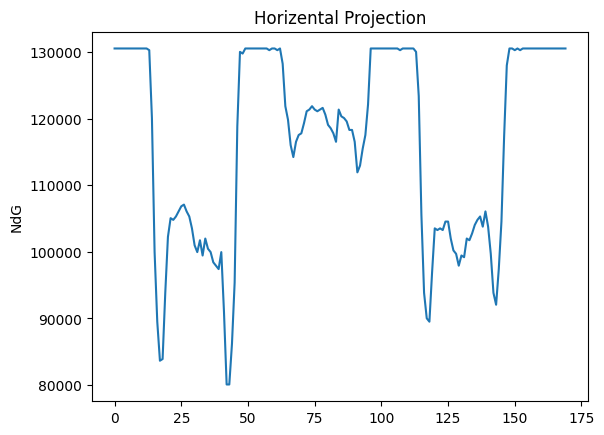

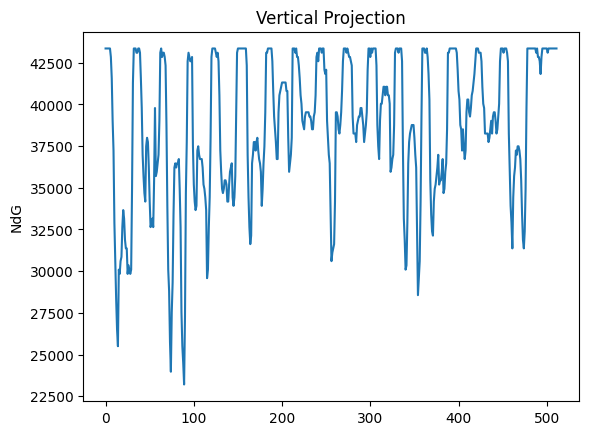

In [230]:
plot_projection(img)
plot_projection(img, "V")

# Histogram

In [231]:
def histogram(img, normal=False, cumulative=False):
    img_int = img.astype(int)
    intensities, counts_ = np.unique(img_int, return_counts=True)
    counts = np.zeros(256)
    counts[intensities] = counts_
    if normal:
        counts = counts/img_int.size

    if cumulative:
        counts = np.cumsum(counts)   

    return intensities, counts     

def plot_hist(img, normal=False, cumulative=False, title="Histogram"):
    _, counts = histogram(img, normal, cumulative)
    plt.title(title), plt.xlabel("NdG"), plt.ylabel("#NdG")
    plt.bar(range(256), counts)    

In [232]:
def hist_stretch(img, bornes='minmax'):
    if bornes == 'minmax':
        inf = img.min()
        sup = img.max()
    else:
        inf = np.percentile(img, 10)
        sup = np.percentile(img, 90)
        
    return (img - inf)/(sup - inf)*255

In [233]:
def hist_equal(img):
    _, counts = histogram(img, normal=True, cumulative=True)
    return np.round(counts[img]*255)

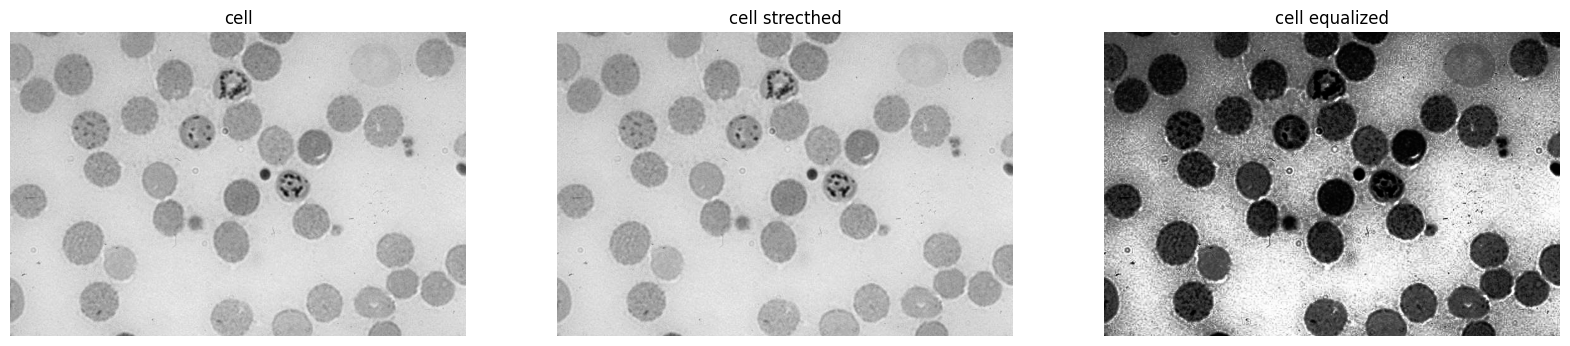

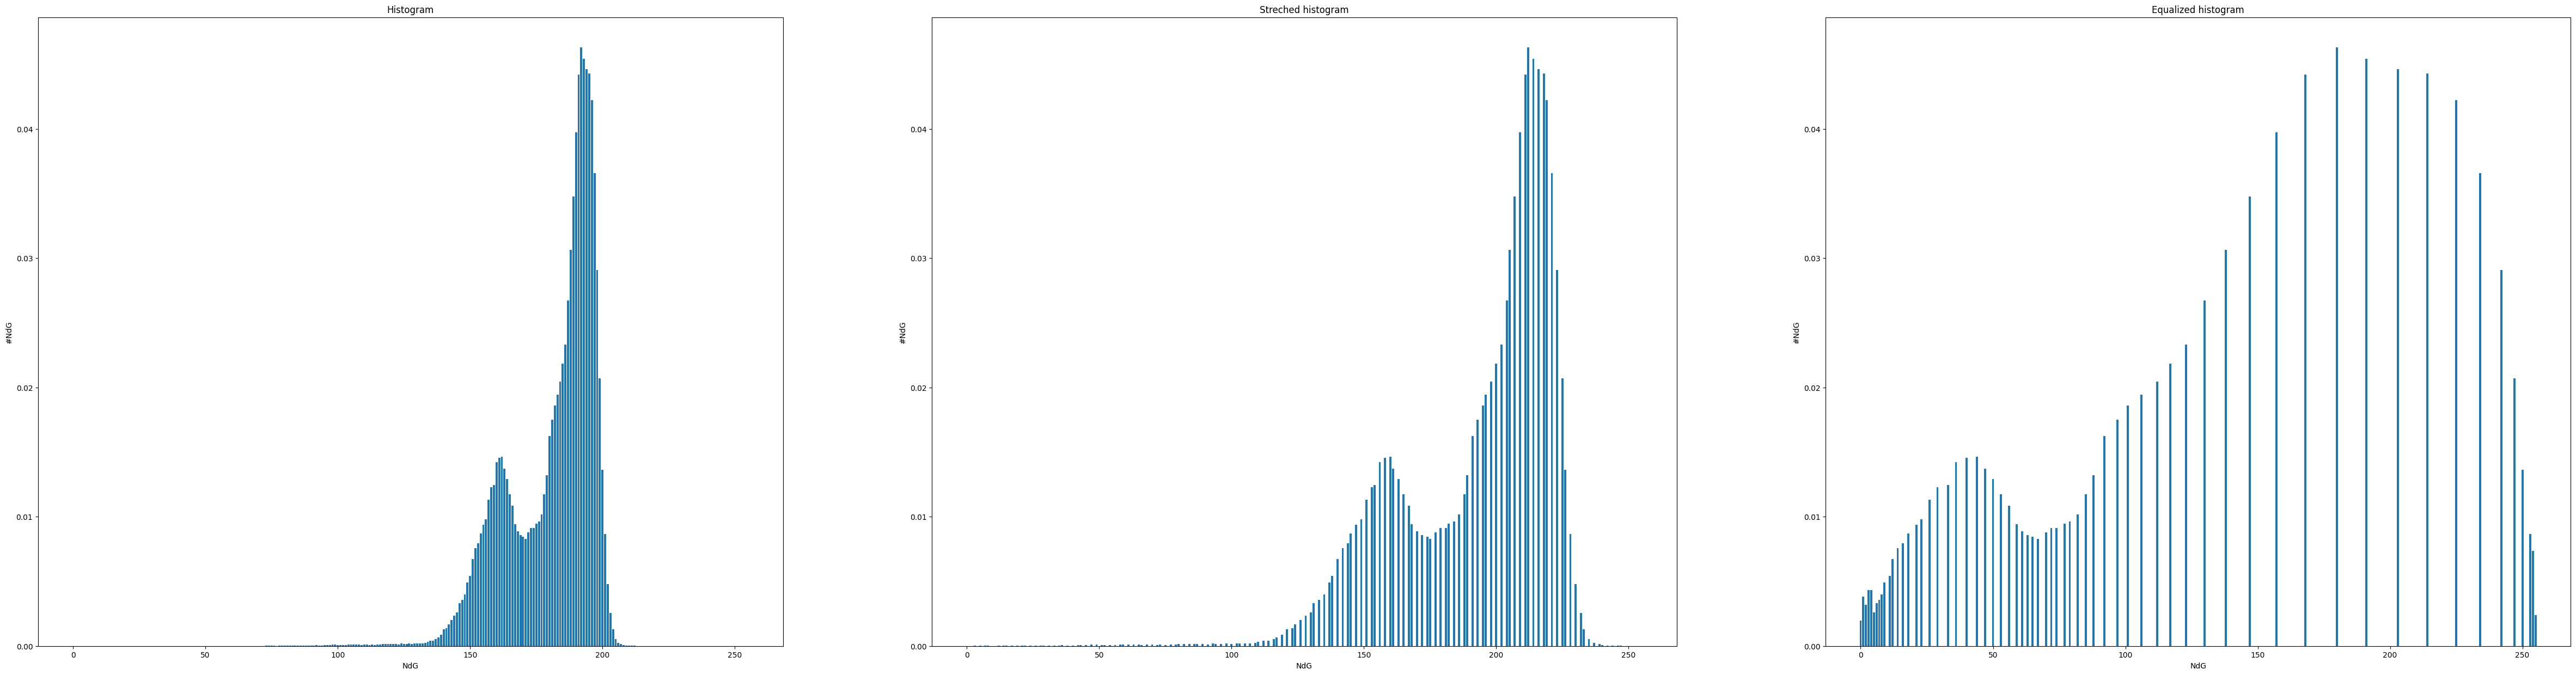

In [234]:
img_path = "img/cell.jpg"

# Loading Images
img = read_img(img_path)
str_img = hist_stretch(img)
equ_img = hist_equal(img)

# Plot the images
plt.figure(figsize=[20, 60])
plt.subplot(131), show_img(img, "cell")
plt.subplot(132), show_img(str_img, "cell strecthed")
plt.subplot(133), show_img(equ_img, "cell equalized")
plt.show()

# Plot the histograms
plt.figure(figsize=[60, 15])
plt.subplot(131), plot_hist(img, normal=True)
plt.subplot(132), plot_hist(str_img, normal=True, title="Streched histogram")
plt.subplot(133), plot_hist(equ_img, normal=True, title="Equalized histogram")
plt.show()

# Gamma Correction